# Retrieving data

In [36]:
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from urllib.parse import quote_plus

def get_html(driver, job_name, page_number):
    encoded_job_name = quote_plus(job_name)
    url = f'https://nofluffjobs.com/?criteria=jobPosition%3D%27{encoded_job_name}%27&page={page_number}'
    driver.get(url)
    html_content = driver.page_source
    return html_content

def save_html_to_file(html_content, job_name, page_number):
    filename = f'/Users/katka/Desktop/project_folder/data/raw/{job_name}_{page_number}.html'
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(html_content)

driver = webdriver.Chrome()

def retrieve_and_save_first_page(driver, job_name, page_number):
    html_content = get_html(driver, job_name, page_number)
    save_html_to_file(html_content, job_name, page_number)

retrieve_and_save_first_page(driver, 'data scientist', 10)
retrieve_and_save_first_page(driver, 'data analyst', 10)
retrieve_and_save_first_page(driver, 'data engineer', 10)

driver.close()
driver.quit()




# Scrapping data

In [37]:
import os
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
import re

def extract_single_ads(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')
    job_ads = soup.find_all('a', class_='posting-list-item')
    return job_ads

def parse_single_ad(ad_html, role):
    soup = BeautifulSoup(ad_html, 'html.parser')

    ad_info = {
        'name': '',
        'company': '',
        'technology': '',
        'job': f'data {role}',
        'location': {'city': '', 'country': ''},
        'salary': {'low': 'N/A', 'high': 'N/A', 'currency': ''}
    }

    name_tag = soup.find('h3', class_='posting-title__position')
    if name_tag:
        ad_info['name'] = name_tag.get_text(strip=True)

    company_tag = soup.find('h4', class_='company-name')
    if company_tag:
        ad_info['company'] = company_tag.get_text(strip=True)

    technology_tags = soup.find_all('span', class_='tw-text-gray-60')
    ad_info['technology'] = ', '.join([tag.get_text(strip=True) for tag in technology_tags if tag.get('data-cy') == 'category name on the job offer listing'])
    
    location_tag = soup.find('span', class_='tw-text-ellipsis tw-inline-block tw-overflow-hidden tw-whitespace-nowrap tw-max-w-[100px] md:tw-max-w-[200px] tw-text-right')
    if location_tag:
        location_text = location_tag.get_text(strip=True).split(',')
        ad_info['location']['city'] = 'Remote' if not location_tag else location_text[0].strip()
        ad_info['location']['country'] = 'N/A' if len(location_text) == 1 else location_text[1].strip()
    
    salary_tag = soup.find('span', attrs={'data-cy': 'salary ranges on the job offer listing'})
    if salary_tag:
        salary_text = salary_tag.get_text(strip=True)
        salary_numbers = re.findall(r'\d+', salary_text.replace('\xa0', ''))
        ad_info['salary']['low'] = salary_numbers[0] if salary_numbers else 'N/A'
        ad_info['salary']['high'] = salary_numbers[1] if len(salary_numbers) > 1 else ad_info['salary']['low']
        ad_info['salary']['currency'] = ''.join(re.findall(r'[a-zA-Z]+', salary_text))

    return ad_info

roles = ['engineer', 'scientist', 'analyst']

raw_data_dir = '/Users/katka/Desktop/project_folder/data/raw'
interim_data_dir = '/Users/katka/Desktop/project_folder/data/interim'

dataframes = {}

for role in roles:
    job_ads_list = []
    output_file = interim_data_dir + f'/job_offers_{role}_{datetime.today().strftime("%Y_%m_%d")}.csv'

    for filename in os.listdir(raw_data_dir):
        if role in filename and filename.endswith('.html'):
            file_path = os.path.join(raw_data_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                html_code = file.read()
                single_ads = extract_single_ads(html_code)
                for ad in single_ads:
                    ad_info = parse_single_ad(str(ad), role)
                    if (role.lower() == 'analyst' and 'analyst' in ad_info['name'].lower() and 'data' in ad_info['name'].lower()) or \
                       (role.lower() == 'engineer' and 'engineer' in ad_info['name'].lower() and 'data' in ad_info['name'].lower()) or \
                       (role.lower() == 'scientist' and role.lower() in ad_info['name'].lower()):
                        job_ads_list.append(ad_info)

    dataframes[f'df_{role}'] = pd.DataFrame(job_ads_list)

df_engineer = dataframes['df_engineer']
df_scientist = dataframes['df_scientist']
df_analyst = dataframes['df_analyst']

df_engineer.to_csv(interim_data_dir + '/job_offers_engineer.csv', sep=';', encoding='utf-8', index=False)
df_scientist.to_csv(interim_data_dir + '/job_offers_scientist.csv', sep=';', encoding='utf-8', index=False)
df_analyst.to_csv(interim_data_dir + '/job_offers_analyst.csv', sep=';', encoding='utf-8', index=False)



In [38]:
def print_unique_cities(df, role_name):
    # Extracting city names from the 'location' column, which contains dictionaries
    df['location_city'] = df['location'].apply(lambda x: x.get('city') if x.get('city') != 'Remote' else 'N/A')

    # Filtering out 'Remote' and 'N/A'
    filtered_cities = df[df['location_city'] != 'N/A']['location_city']
    unique_cities = filtered_cities.unique()

    # Printing unique cities for the given role
    print(f"Unique cities for {role_name}:")
    for city in unique_cities:
        print(city)
    print("\n")

# Assuming df_engineer, df_scientist, df_analyst are your actual DataFrame variable names
print_unique_cities(df_engineer, 'Data Engineer')
print_unique_cities(df_scientist, 'Data Scientist')
print_unique_cities(df_analyst, 'Data Analyst')


Unique cities for Data Engineer:
Warszawa
Kraków
Krakow
Poznań
Budapest
Wrocław
Warsaw
Katowice
Gdańsk


Unique cities for Data Scientist:
Budapest
Kraków
Katowice
Gdynia
Warsaw


Unique cities for Data Analyst:
Kraków
Poznań
Gdańsk
Cracow
Katowice
Warsaw
Budapest
Warszawa




# Transforming data

In [17]:
import pandas as pd
import ast
def clean_and_transform(df):
    df['location'] = df['location'].apply(ast.literal_eval)
    df['salary'] = df['salary'].apply(ast.literal_eval)

    df['location_city'] = df['location'].apply(lambda x: x.get('city', 'N/A').lower())
    
    city_corrections = {
        'wroclove': 'wroclaw',
        'krak√≥w': 'krakow',
        'gda≈ñsk': 'gdansk',
        'warsaw': 'warszawa',
        'crakow': 'krakow'
    }
    df['location_city'] = df['location_city'].replace(city_corrections)

    df['location_country'] = df.apply(
        lambda row: 'HU' if 'budapest' in row['location_city'] else ('N/A' if row['location_city'] == 'remote' else 'PL'),
        axis=1
    )

    df['salary_low'] = pd.to_numeric(df['salary'].apply(lambda x: x['low'] if x['low'] != 'N/A' else None), errors='coerce')
    df['salary_high'] = pd.to_numeric(df['salary'].apply(lambda x: x['high'] if x['high'] != 'N/A' else x['low']), errors='coerce')
    df['salary_avg'] = df[['salary_low', 'salary_high']].mean(axis=1)


    df['is_senior'] = df['name'].apply(lambda x: 1 if 'senior' in x.lower() else 0)


    df['name'] = df['name'].str.lower()


    df.drop(['location', 'salary'], axis=1, inplace=True)

    return df


interim_data_dir = '/Users/katka/Desktop/project_folder/data/interim'
output_folder = '/Users/katka/Desktop/project_folder/data/pro/'

df_engineer = pd.read_csv(os.path.join(interim_data_dir, 'job_offers_engineer.csv'), sep=';', encoding='utf-8')
df_scientist = pd.read_csv(os.path.join(interim_data_dir, 'job_offers_scientist.csv'), sep=';', encoding='utf-8')
df_analyst = pd.read_csv(os.path.join(interim_data_dir, 'job_offers_analyst.csv'), sep=';', encoding='utf-8')

df_engineer_cleaned = clean_and_transform(df_engineer)
df_scientist_cleaned = clean_and_transform(df_scientist)
df_analyst_cleaned = clean_and_transform(df_analyst)


df_engineer_cleaned.to_csv(os.path.join(output_folder, 'job_offers_engineer_cleaned.csv'), sep=';', encoding='utf-8', index=False)
df_scientist_cleaned.to_csv(os.path.join(output_folder, 'job_offers_scientist_cleaned.csv'), sep=';', encoding='utf-8', index=False)
df_analyst_cleaned.to_csv(os.path.join(output_folder, 'job_offers_analyst_cleaned.csv'), sep=';', encoding='utf-8', index=False)


# Data analysis

# question 1

In [14]:
num_jobs_engineer = df_engineer_cleaned.shape[0]
num_jobs_scientist = df_scientist_cleaned.shape[0]
num_jobs_analyst = df_analyst_cleaned.shape[0]

print(f"Number of job offers for Data Engineer: {num_jobs_engineer}")
print(f"Number of job offers for Data Scientist: {num_jobs_scientist}")
print(f"Number of job offers for Data Analyst: {num_jobs_analyst}")


Number of job offers for Data Engineer: 64
Number of job offers for Data Scientist: 20
Number of job offers for Data Analyst: 16


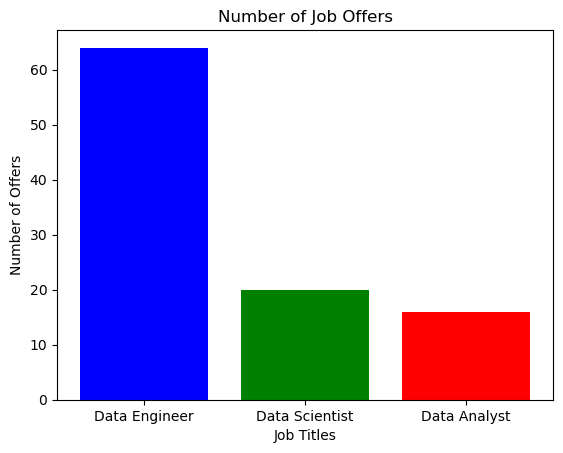

In [25]:
import matplotlib.pyplot as plt


job_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst']
num_jobs = [num_jobs_engineer, num_jobs_scientist, num_jobs_analyst]

plt.bar(job_titles, num_jobs, color=['blue', 'green', 'red'])

plt.title('Number of Job Offers')
plt.xlabel('Job Titles')
plt.ylabel('Number of Offers')

plt.show()


# question 2

In [15]:
avg_salary_engineer = df_engineer_cleaned['salary_avg'].mean()
avg_salary_scientist = df_scientist_cleaned['salary_avg'].mean()
avg_salary_analyst = df_analyst_cleaned['salary_avg'].mean()

print(f"Average salary for Data Engineer: {avg_salary_engineer:.2f} PLN")
print(f"Average salary for Data Scientist: {avg_salary_scientist:.2f} PLN")
print(f"Average salary for Data Analyst: {avg_salary_analyst:.2f} PLN")

Average salary for Data Engineer: 22651.26 PLN
Average salary for Data Scientist: 22523.75 PLN
Average salary for Data Analyst: 20776.47 PLN


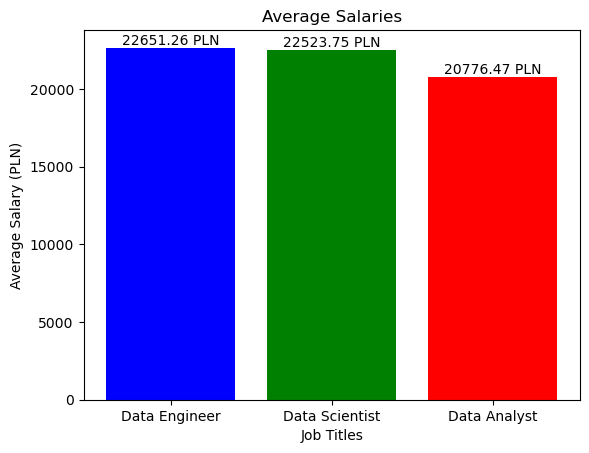

In [27]:
import matplotlib.pyplot as plt


job_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst']
avg_salaries = [avg_salary_engineer, avg_salary_scientist, avg_salary_analyst]

plt.bar(job_titles, avg_salaries, color=['blue', 'green', 'red'])

plt.title('Average Salaries')
plt.xlabel('Job Titles')
plt.ylabel('Average Salary (PLN)')

for i in range(len(avg_salaries)):
    plt.text(i, avg_salaries[i], f'{avg_salaries[i]:.2f} PLN', ha = 'center', va = 'bottom')

plt.show()


# question 3

In [19]:
combined_df = pd.concat([df_engineer_cleaned, df_scientist_cleaned, df_analyst_cleaned])

city_job_counts = combined_df[combined_df['location_city'] != 'remote']['location_city'].value_counts()

top_5_cities = city_job_counts.head(5)

print("Top 5 cities with the most job offers:")
print(top_5_cities)


Top 5 cities with the most job offers:
location_city
warszawa    20
kraków      10
budapest     8
gdańsk       4
katowice     3
Name: count, dtype: int64


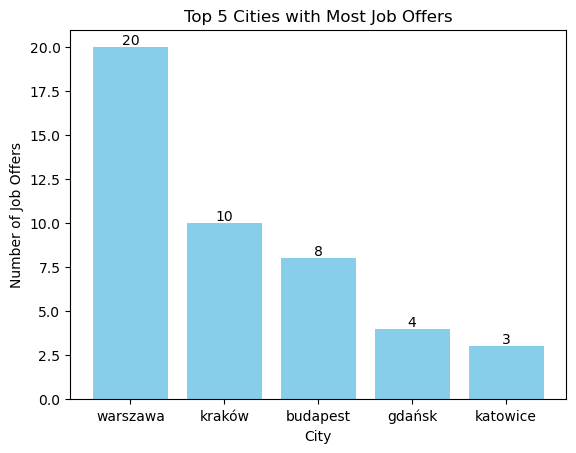

In [28]:
import matplotlib.pyplot as plt

cities = top_5_cities.index
job_counts = top_5_cities.values

plt.bar(cities, job_counts, color='skyblue')

plt.title('Top 5 Cities with Most Job Offers')
plt.xlabel('City')
plt.ylabel('Number of Job Offers')

for i in range(len(cities)):
    plt.text(i, job_counts[i], job_counts[i], ha='center', va='bottom')

plt.show()


# question 4

In [20]:

average_salary_per_city = combined_df[combined_df['location_city'] != 'N/A'].groupby('location_city')['salary_avg'].mean()


highest_salary_city = average_salary_per_city.idxmax()
highest_salary_amount = average_salary_per_city.max()


print(f"The highest average salary is offered in {highest_salary_city}, with an average of {highest_salary_amount:.2f} PLN.")



The highest average salary is offered in gdańsk, with an average of 25489.50 PLN.


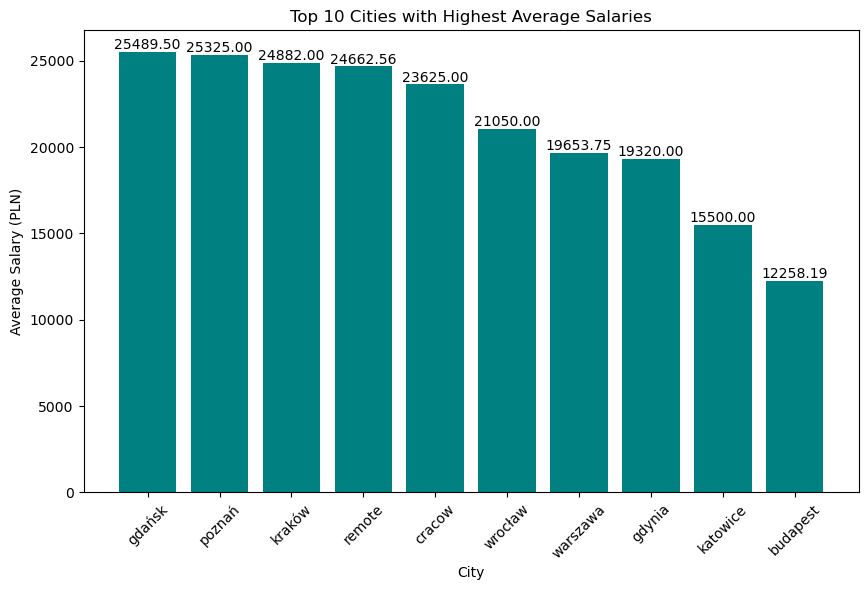

In [29]:
import matplotlib.pyplot as plt

top_cities = average_salary_per_city.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_cities.index, top_cities.values, color='teal')

plt.title('Top 10 Cities with Highest Average Salaries')
plt.xlabel('City')
plt.ylabel('Average Salary (PLN)')


for i in range(len(top_cities)):
    plt.text(i, top_cities.values[i], f"{top_cities.values[i]:.2f}", ha='center', va='bottom')


plt.xticks(rotation=45) 
plt.show()


# question 5

In [24]:
def calculate_salary_difference(df):
    avg_salary_regular = int(df[df['is_senior'] == 0]['salary_avg'].mean())
    avg_salary_senior = int(df[df['is_senior'] == 1]['salary_avg'].mean())
    salary_difference = avg_salary_senior - avg_salary_regular
    return avg_salary_regular, avg_salary_senior, salary_difference

avg_reg_engineer, avg_senior_engineer, diff_engineer = calculate_salary_difference(df_engineer_cleaned)
print(f"Data Engineer - Avg Regular Salary: {avg_reg_engineer}, Avg Senior Salary: {avg_senior_engineer}, Salary Difference: {diff_engineer}")

avg_reg_scientist, avg_senior_scientist, diff_scientist = calculate_salary_difference(df_scientist_cleaned)
print(f"Data Scientist - Avg Regular Salary: {avg_reg_scientist}, Avg Senior Salary: {avg_senior_scientist}, Salary Difference: {diff_scientist}")

avg_reg_analyst, avg_senior_analyst, diff_analyst = calculate_salary_difference(df_analyst_cleaned)
print(f"Data Analyst - Avg Regular Salary: {avg_reg_analyst}, Avg Senior Salary: {avg_senior_analyst}, Salary Difference: {diff_analyst}")


Data Engineer - Avg Regular Salary: 22392, Avg Senior Salary: 23899, Salary Difference: 1507
Data Scientist - Avg Regular Salary: 21068, Avg Senior Salary: 23714, Salary Difference: 2646
Data Analyst - Avg Regular Salary: 20734, Avg Senior Salary: 20902, Salary Difference: 168


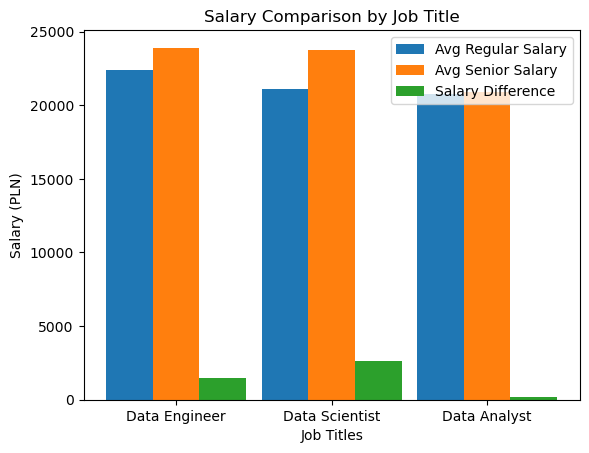

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Data
job_titles = ['Data Engineer', 'Data Scientist', 'Data Analyst']
avg_regular_salaries = [avg_reg_engineer, avg_reg_scientist, avg_reg_analyst]
avg_senior_salaries = [avg_senior_engineer, avg_senior_scientist, avg_senior_analyst]
salary_differences = [diff_engineer, diff_scientist, diff_analyst]

x = np.arange(len(job_titles))

width = 0.3

plt.bar(x - width, avg_regular_salaries, width, label='Avg Regular Salary')
plt.bar(x, avg_senior_salaries, width, label='Avg Senior Salary')
plt.bar(x + width, salary_differences, width, label='Salary Difference')

plt.title('Salary Comparison by Job Title')
plt.xlabel('Job Titles')
plt.ylabel('Salary (PLN)')
plt.xticks(x, job_titles)


plt.legend()

plt.show()


# question 6

In [22]:

min_salary_engineer = df_engineer_cleaned['salary_low'].min()
min_salary_scientist = df_scientist_cleaned['salary_low'].min()
min_salary_analyst = df_analyst_cleaned['salary_low'].min()


total_min_cost = min_salary_engineer + min_salary_scientist + min_salary_analyst

print(f"Minimum salary for Data Engineer: {min_salary_engineer}")
print(f"Minimum salary for Data Scientist: {min_salary_scientist}")
print(f"Minimum salary for Data Analyst: {min_salary_analyst}")
print(f"Total minimum cost for hiring one of each: {total_min_cost}")


Minimum salary for Data Engineer: 7000.0
Minimum salary for Data Scientist: 6611.0
Minimum salary for Data Analyst: 6611.0
Total minimum cost for hiring one of each: 20222.0


# question 7

In [23]:


combined_df = pd.concat([df_engineer_cleaned, df_scientist_cleaned, df_analyst_cleaned])

combined_df = combined_df[combined_df['location_city'] != 'N/A']

cities_with_all_positions = combined_df.groupby('location_city').apply(lambda x: all(job in x['job'].values for job in ['data engineer', 'data scientist', 'data analyst']))

valid_cities = cities_with_all_positions[cities_with_all_positions].index


min_cost_per_city = combined_df[combined_df['location_city'].isin(valid_cities)].groupby('location_city').apply(lambda x: x.groupby('job')['salary_low'].min().sum())


cheapest_city = min_cost_per_city.idxmin()
cheapest_cost = min_cost_per_city.min()

print(f"The cheapest city to form the team is {cheapest_city} with a total minimum cost of {cheapest_cost}")



The cheapest city to form the team is budapest with a total minimum cost of 21486.0


# notes, suggestions:

1.Geographical Focus: The majority of job offers analyzed were from the Polish section of 'NoFluffJobs', due to a lack of substantial data from the Czech Republic. 

2.Language Barriers and Data Interpretation: Given the analysis focused on a Polish website, there could be inaccuracies in interpreting city names and job descriptions due to language barriers. This may lead to potential misclassifications or oversights in the data.

3.Pagination Changes in Web Application: The way for data collection was changed due to changes in the website's pagination. Data was extracted from page 10, which displayed all offers, and offers without explicit role names were excluded. 

4.Uncertainty in Location Data: The approach to categorize 'location_city' and 'location_country' was not clearly defined

5.Lack of Contract Type Information: A significant limitation was the absence of detailed contract type data (e.g., full-time, part-time, contract basis). This omission restricts the depth of analysis regarding salary comparisons, as contract type can significantly impact salary structures.